In [17]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import os, glob, sys, io
import pathlib

from pprint import pprint
import numpy as np
import random
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import scipy
import scipy.signal
import scipy.interpolate

import pickle, yaml
from tqdm.auto import tqdm, trange

from IPython.core.display import display, HTML

In [18]:
with open("dataset-info.yaml", "r") as datasetInfoFile:
    try:
        info = yaml.safe_load(datasetInfoFile)
    except yaml.YAMLError as exc:
        print(exc)
        
        
pickle_batch_root = info['pickle_batch_root']
batch_size = info['batchsize']
maskSize = info['maxsize']
data_root = os.path.join(pickle_batch_root, str(batch_size))

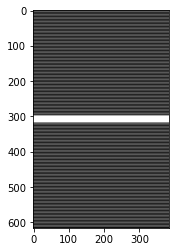

In [19]:
mask_k = np.zeros((maskSize['Ny'], maskSize['Nx']))
mask_k[::4,:] = 1

w = 10;
mask_w = np.zeros((maskSize['Ny'], maskSize['Nx']))
mask_w[maskSize['Ny']//2-w:maskSize['Ny']//2+w,:] = 1

mask_t = np.logical_or(mask_k, mask_w)

plt.imshow(mask_t, cmap='gray')#,interpolation='none')
plt.show()

In [28]:
class KSpaceCatGenerator(tf.keras.utils.Sequence):
    def __init__(self, pickle_root_dir, mask, axis):
        self.filenames = glob.glob(pickle_root_dir+"/*.pickle")
        self.mask = mask
        self.data_root = pickle_root_dir
        self.axis = axis
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, index):
        return self.getitem(index)
        
    def getitem(self, index):
        with open(self.filenames[index], 'rb') as f:
            padded = pickle.load(f)
        inp = self.to_float(padded*self.mask, self.axis)
        out1 = self.to_float(padded, self.axis)
        return inp, out1
    
    
    def get_batch_size(self):
        return int(pathlib.Path(self.data_root).stem)
    
    @staticmethod
    def to_float(X, axis):
        return np.concatenate([X.real, X.imag], axis=axis)
    @staticmethod
    def to_complex(X, axis):
        ax = np.mod(axis, 4)
        n = X.shape[ax] // 2
        if   ax == 0: a = X[:n,:,:,:] + 1j * X[n:,:,:,:]
        elif ax == 1: a = X[:,:n,:,:] + 1j * X[:,n:,:,:]
        elif ax == 2: a = X[:,:,:n,:] + 1j * X[:,:,n:,:]
        elif ax == 3: a = X[:,:,:,:n] + 1j * X[:,:,:,n:]
        else: raise Exception("not suported axis")
        return a
        
    def transform_to_image_coils(self, data):
        return np.fft.fftshift(scipy.fft.fft2(self.to_complex(data, self.axis), workers=os.cpu_count()))
    def combine_coil_images(self, im):
        return np.sqrt(np.sum(im**2,1))
    def transform_to_images(self, data):
        return self.combine_coil_images(self.transform_to_image_coils(data))
   


In [29]:
cat_axis = 1;
kspacegen = KSpaceCatGenerator(data_root, mask_t, cat_axis)
print(len(kspacegen))
print(kspacegen.get_batch_size())

28
64


In [23]:
%time X,Y = kspacegen[0] 

Wall time: 3.03 s


In [25]:
batch_shape = Y.shape
batch_shape

(64, 30, 616, 384)

Wall time: 4.96 s


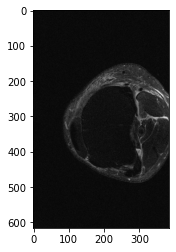

Wall time: 4.97 s


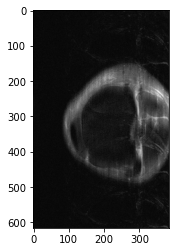

In [30]:
%time images = kspacegen.transform_to_images(Y)
plt.imshow(np.abs(images[5]), cmap='gray')
plt.show()
%time images_alias = kspacegen.transform_to_images(X)
plt.imshow(np.abs(images_alias[5]), cmap='gray')
plt.show()

In [26]:
# declaring the input layer
# In the original paper the network consisted of only one channel.
inputs = layers.Input(shape=batch_shape[1:])
# first part of the U - contracting part
c0 = layers.Conv2D(64, activation='relu', kernel_size=3)(inputs)
c1 = layers.Conv2D(64, activation='relu', kernel_size=3)(c0)  # This layer for concatenating in the expansive part
c2 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c1)

c3 = layers.Conv2D(128, activation='relu', kernel_size=3)(c2)
c4 = layers.Conv2D(128, activation='relu', kernel_size=3)(c3)  # This layer for concatenating in the expansive part
c5 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c4)

c6 = layers.Conv2D(256, activation='relu', kernel_size=3)(c5)
c7 = layers.Conv2D(256, activation='relu', kernel_size=3)(c6)  # This layer for concatenating in the expansive part
c8 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c7)

c9 = layers.Conv2D(512, activation='relu', kernel_size=3)(c8)
c10 = layers.Conv2D(512, activation='relu', kernel_size=3)(c9)  # This layer for concatenating in the expansive part
c11 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c10)

c12 = layers.Conv2D(1024, activation='relu', kernel_size=3)(c11)
c13 = layers.Conv2D(1024, activation='relu', kernel_size=3, padding='valid')(c12)

# We will now start the second part of the U - expansive part
t01 = layers.Conv2DTranspose(512, kernel_size=2, strides=(2, 2), activation='relu')(c13)
crop01 = layers.Cropping2D(cropping=(4, 4))(c10)

concat01 = layers.concatenate([t01, crop01], axis=-1)

c14 = layers.Conv2D(512, activation='relu', kernel_size=3)(concat01)
c15 = layers.Conv2D(512, activation='relu', kernel_size=3)(c14)

t02 = layers.Conv2DTranspose(256, kernel_size=2, strides=(2, 2), activation='relu')(c15)
crop02 = layers.Cropping2D(cropping=(16, 16))(c7)

concat02 = layers.concatenate([t02, crop02], axis=-1)

c16 = layers.Conv2D(256, activation='relu', kernel_size=3)(concat02)
c17 = layers.Conv2D(256, activation='relu', kernel_size=3)(c16)

t03 = layers.Conv2DTranspose(128, kernel_size=2, strides=(2, 2), activation='relu')(c17)
crop03 = layers.Cropping2D(cropping=(40, 40))(c4)

concat03 = layers.concatenate([t03, crop03], axis=-1)

c18 = layers.Conv2D(128, activation='relu', kernel_size=3)(concat03)
c19 = layers.Conv2D(128, activation='relu', kernel_size=3)(c18)

t04 = layers.Conv2DTranspose(64, kernel_size=2, strides=(2, 2), activation='relu')(c19)
crop04 = layers.Cropping2D(cropping=(88, 88))(c1)

concat04 = layers.concatenate([t04, crop04], axis=-1)

c20 = layers.Conv2D(64, activation='relu', kernel_size=3)(concat04)
c21 = layers.Conv2D(64, activation='relu', kernel_size=3)(c20)

outputs = layers.Conv2D(2, kernel_size=1)(c21)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="u-netmodel")

ValueError: Negative dimension size caused by subtracting 3 from 2 for '{{node conv2d_5/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](conv2d_4/Relu, conv2d_5/Conv2D/ReadVariableOp)' with input shapes: [?,2,149,256], [3,3,256,256].

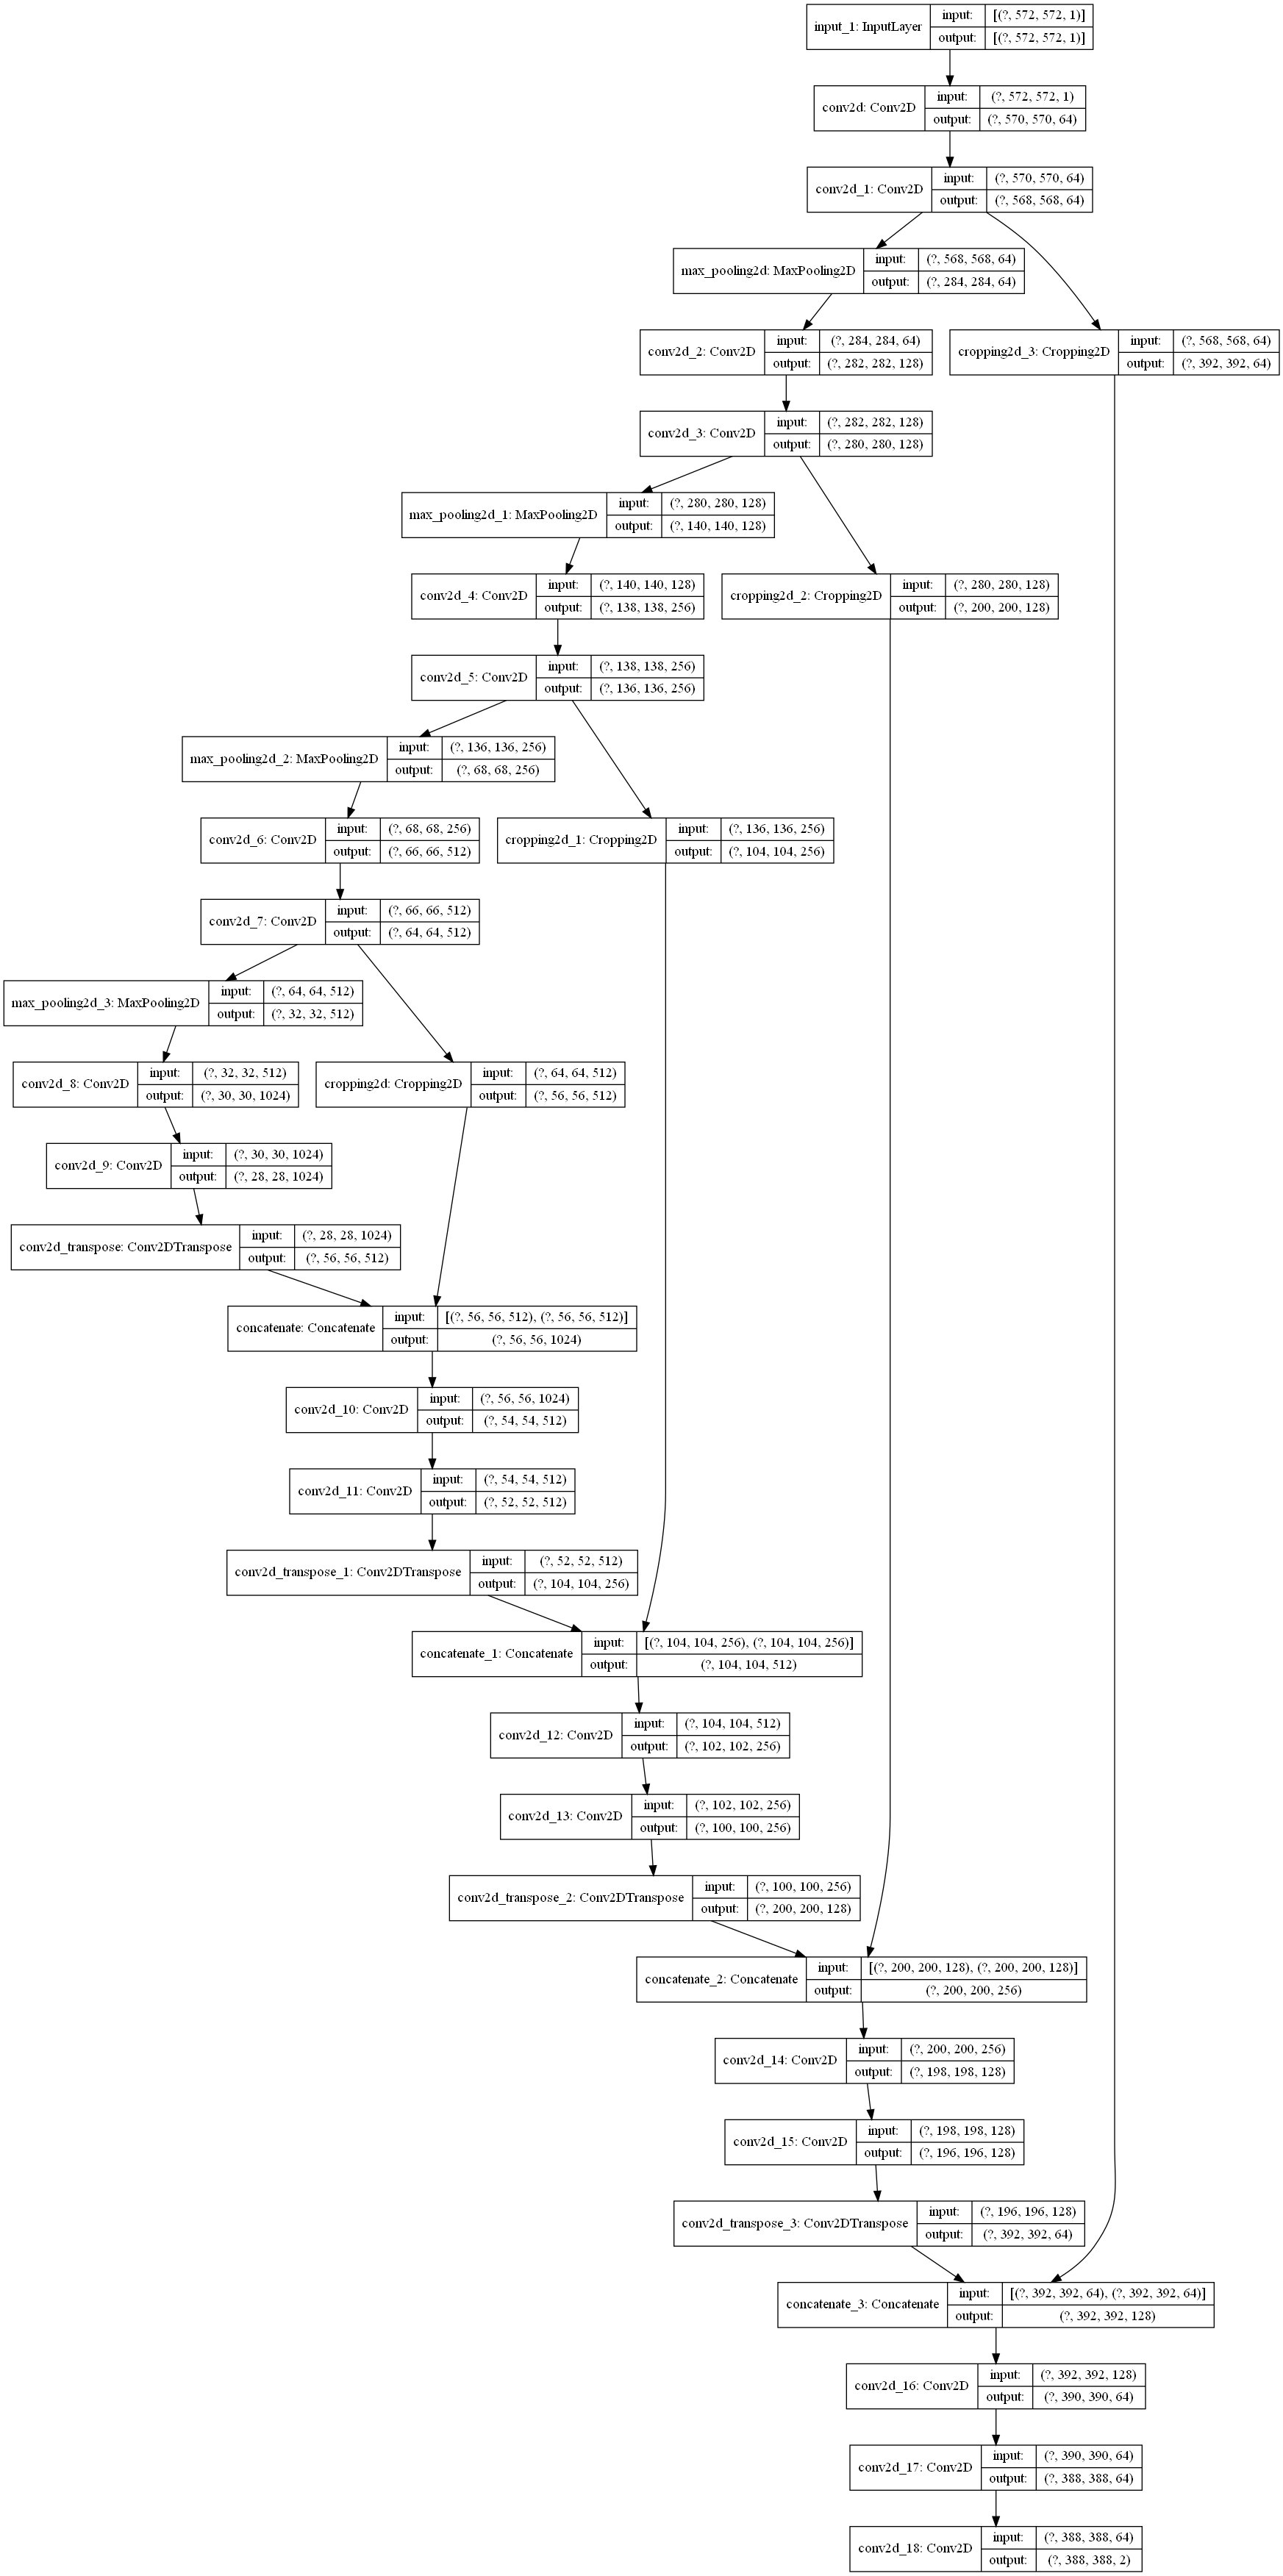

In [3]:
tf.keras.utils.plot_model(model, "unet.png", True)